In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from iuvs import meta, io

In [4]:
l1b_metadata = meta.l1b_summary()

In [5]:
!head -n 28 {meta.stagel1bsummary}

filenum - file number
filename - 
OBS_ID - observation setup identifier
XUV - channel (FUV or MUV)
INT_TIME - integration time (seconds)
NX - number of pixels in the x (spectral) dimension
NY - number of pixels in the y (spatial) dimension
NZ - number of readouts
X1 - first spectral pixel
X2 - last spectral pixel
Y1 - first spatial pixel
Y2 - last spatial pixel
BINX - bin width in x (spectral) dimension
BINY - bin width in y (spatial) dimension
MCP_HV - voltage across the microchannel plate
SHUT_STATE - either open or closed, derived from commanding
PHASE - name of the observation phase
MODE - numerical id of the mode, which defines the instrument setup
CYCLE - repetition number of the mode
DET_TEMP - Detector temperature (degC)
CASE_TEMP - Case temperature (degC)
FOV_DEG - Look angle relative to -k axis (center of nadir FOR would be 90deg)
STIM_STATE - if the stim lamp is on
FILL_BINS - number of fill bins in the observation
TARGET - target of observation
PURPOSE - description of obse

In [6]:
cruisecals = l1b_metadata[l1b_metadata.filename.str.contains('cruisecal')]

In [7]:
cruisecals.columns

Index(['filename', 'OBS_ID', 'XUV', 'INT_TIME', 'NX', 'NY', 'NZ', 'X1', 'X2', 'Y1', 'Y2', 'BINX', 'BINY', 'MCP_HV', 'SHUT_STATE', 'PHASE', 'MODE', 'CYCLE', 'DET_TEMP', 'CASE_TEMP', 'FOV_DEG', 'STIM_STATE', 'FILL_BINS', 'TARGET', 'PURPOSE'], dtype='object')

In [8]:
%pylab inline
rcParams['figure.figsize'] = (10,10)

Populating the interactive namespace from numpy and matplotlib


In [13]:
from iuvs import plotting

In [29]:
for col in cruisecals.columns[1:]:
    print(col)
    print(cruisecals[col].value_counts())

OBS_ID
12     10
431     8
433     8
132     8
133     8
432     8
131     8
70      6
11      4
320     3
260     3
340     2
120     2
420     2
540     2
520     2
220     2
240     2
92      1
290     1
91      1
250     1
dtype: int64
XUV
FUV    50
MUV    42
dtype: int64
INT_TIME
4000     47
2000     22
1000     19
60000     4
dtype: int64
NX
512    54
29     14
17     11
256     6
201     4
40      3
dtype: int64
NY
4      54
93     14
112    11
11      6
287     4
6       3
dtype: int64
NZ
56     64
218    10
46      6
219     4
1       4
16      3
28      1
dtype: int64
X1
0      71
1      14
149     3
138     3
139     1
dtype: int64
X2
1023    60
1015    14
1019    11
188      3
539      3
540      1
dtype: int64
Y1
382    12
340    12
381    12
338    12
1       7
0       7
100     3
499     3
128     3
495     3
749     2
104     1
803     1
905     1
402     1
403     1
282     1
284     1
48      1
46      1
102     1
325     1
326     1
459     1
747     1
99      1
458 

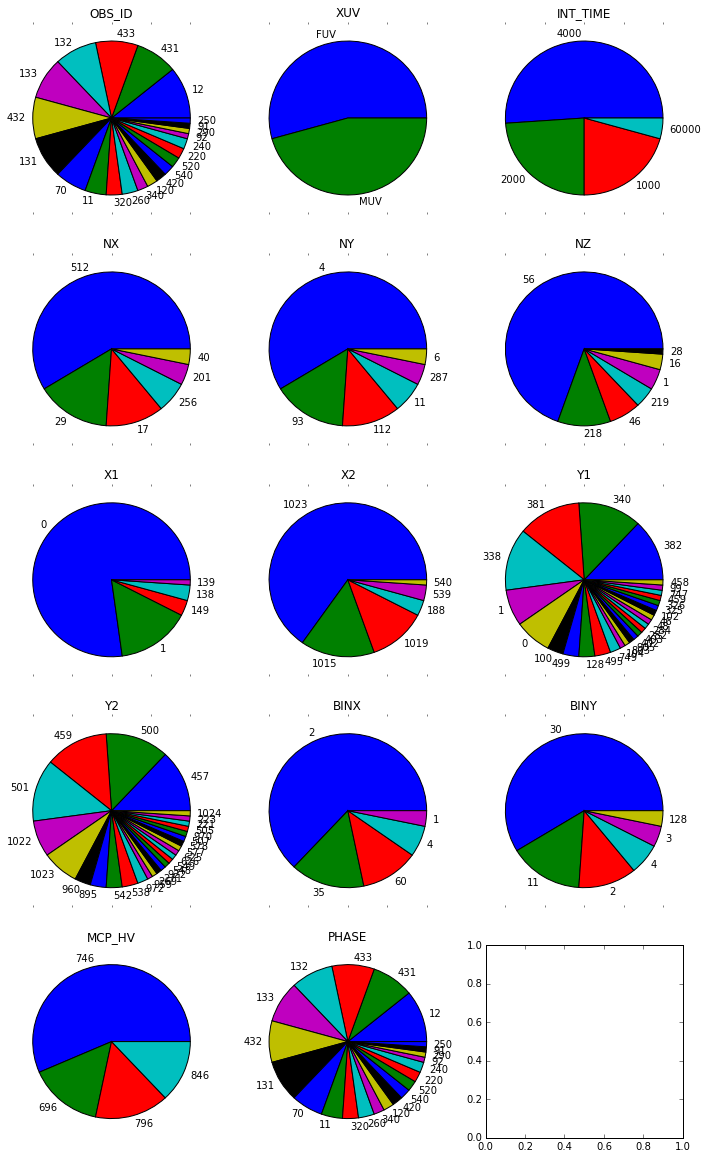

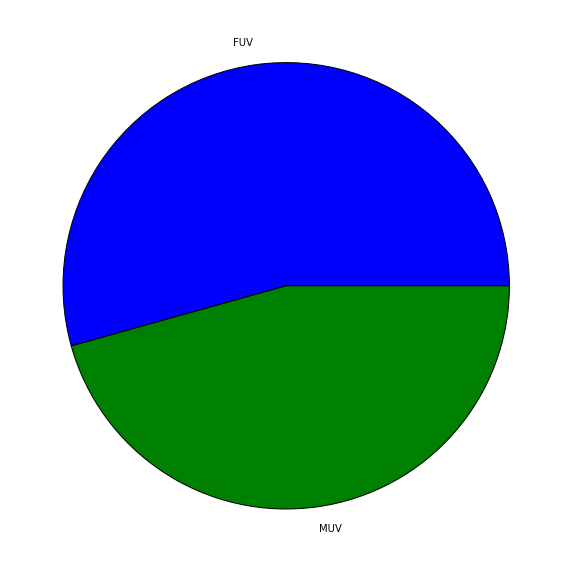

In [17]:
plotting.get_pie_plot(cruisecals, 'XUV');

In [14]:
import pickle
with open('two_or_more.pck', 'rb') as f:
    two_or_more = pickle.load(f)

In [55]:
df = cruisecals[cruisecals.filename.isin(two_or_more)].copy()
df.head()

,filename,OBS_ID,XUV,INT_TIME,NX,NY,NZ,X1,X2,Y1,...,PHASE,MODE,CYCLE,DET_TEMP,CASE_TEMP,FOV_DEG,STIM_STATE,FILL_BINS,TARGET,PURPOSE
filenum,,,,,,,,,,,,,,,,,,,,,
651,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,11,MUV,4000,29,93,218,1,1015,1,...,11,-1,-12.870,-10.8130,0.01,31610Siding,Spr,Spectral,NaN,NaN
653,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,11,MUV,4000,29,93,219,1,1015,1,...,11,-1,-13.020,-7.7153,11.98,31755Siding,Spr,Spectral,NaN,NaN
654,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,12,FUV,4000,29,93,218,1,1015,0,...,12,-1,-11.072,-5.4229,60.01,108346Siding,Spr,Spectral,NaN,NaN
655,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,12,MUV,4000,29,93,218,1,1015,1,...,12,-1,-12.870,-5.4229,60.01,31610Siding,Spr,Spectral,NaN,NaN
656,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,12,FUV,4000,29,93,218,1,1015,0,...,12,-1,-10.848,-3.4085,71.98,108346Siding,Spr,Spectral,NaN,NaN


In [18]:
from IPython.parallel import Client
c = Client()

In [19]:
lbview = c.load_balanced_view()

In [20]:
def do_dark_fit(fname):
    from iuvs import scaling, io
    l1b = io.L1BReader(str(io.stagelevel1bpath / fname))
    darkout = l1b.detector_dark[-1]
    darkin = l1b.detector_dark[-2]
    scaler = scaling.PolyScaler(darkin, darkout)
    scaler.do_fit()
    return (fname, scaler.p)

In [21]:
res = lbview.map_async(do_dark_fit, two_or_more)

In [22]:
for item in res:
    print(item)

('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T165419_v01_r01.fits.gz', array([  1.08658786e-04,   2.92508222e-01,   2.88277513e+02]))
('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T171232_v01_r01.fits.gz', array([  1.08658786e-04,   2.92508222e-01,   2.88277513e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T173118_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T173118_v01_r01.fits.gz', array([  8.99629318e-05,   7.50773517e-01,   3.24376253e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T174929_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T174929_v01_r01.fits.gz', array([  8.99629318e-05,   7.50773517e-01,   3.24376253e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T180740_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T180740_v01_r01.f

In [59]:
for item in res:
    p = item[1]
    df.loc[df.filename==item[0],'n2coeffs'] = p[0]
    df.loc[df.filename==item[0],'n1coeffs'] = p[1]
    df.loc[df.filename==item[0],'n0coeffs'] = p[2]

In [61]:
df.drop('TARGET PURPOSE SHUT_STATE MODE'.split(), axis=1, inplace=True)

In [65]:
muv = df[df.XUV == 'MUV']
fuv = df[df.XUV == 'FUV']

In [98]:
muv_dark_fnames = []
for fname in muv.filename:
    print(fname)
    l1b = io.L1BReader(fname)
    for line in l1b.DarkIntegration_header['COMMENT']:
        if not line.startswith('mvn_iuv'):
            continue
        muv_dark_fnames.append(line)
    muv.loc[muv.filename == fname, 'darktime'] = io.Filename(muv_dark_fnames[-1]).time

mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T165419_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T171232_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T173118_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T174929_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T180740_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T182551_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T184405_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode120-muv_20140402T190257_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode220-muv_20140402T200620_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode240-muv_20140402T201135_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode320-muv_20140402T204936_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode340-muv_20140402T205451_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode420-muv_20140402T210029_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode520-muv_20140402T220356_v01_r01.fits.gz
mvn_iuv_l1b_cruisecal1-mode540-muv_20140402T220911_v01_r01.fit

/usr/local/python3/miniconda/lib/python3.4/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/usr/local/python3/miniconda/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [100]:
muv_dark_fnames

['mvn_iuv_l1a_cruisecal1-mode011-muvdark_20140402T165408_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode011-muvdark_20140402T173053_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode011-muvdark_20140402T165408_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode011-muvdark_20140402T173053_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T173107_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T190225_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T173107_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T190225_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T173107_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T190225_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T173107_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T190225_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-mode012-muvdark_20140402T173107_v01_r01.fits.gz',
 'mvn_iuv_l1a_cruisecal1-

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
%autocall

Automatic calling is: Smart


-> plot(n2coeffs)


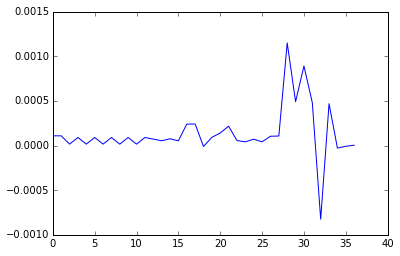

In [27]:
plot n2coeffs

-> plot(n1coeffs)


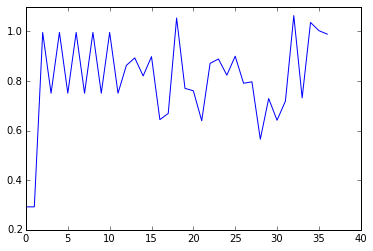

In [28]:
plot n1coeffs

-> plot(n0coeffs)


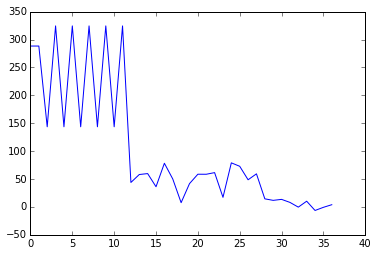

In [29]:
plot n0coeffs

In [108]:
df = pd.DataFrame.from_items(res).T

In [109]:
df = df.reset_index()

In [110]:
df.head()

,index,0,1,2
0,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
1,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
3,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
4,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499


In [111]:
df.columns = ['filename', 'coeff_2','coeff_1','coeff_0'] 

In [112]:
df.head()

,filename,coeff_2,coeff_1,coeff_0
0,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
1,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
3,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
4,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499


In [113]:
def get_time(fname):
    return io.Filename(fname).time

In [114]:
df['time'] = df.filename.map(get_time)

In [115]:
df.set_index('time', inplace=True)

In [116]:
df.iloc[:10]

,filename,coeff_2,coeff_1,coeff_0
time,,,,
2014-04-02 16:54:19,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
2014-04-02 17:12:32,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2014-04-02 17:31:18,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
2014-04-02 17:31:18,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
2014-04-02 17:49:29,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
2014-04-02 17:49:29,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
2014-04-02 18:07:40,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T18...,0.000015,0.995765,143.575499
2014-04-02 18:07:40,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T18...,0.000090,0.750774,324.376253
2014-04-02 18:25:51,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T18...,0.000015,0.995765,143.575499


In [120]:
same_p_fnames = df.filename.iloc[:2].values

In [121]:
import os

In [122]:
os.path.isabs(same_p_fnames[0])

False

In [ ]:
f1 = io.L1BReader(same_p_fnames[0]

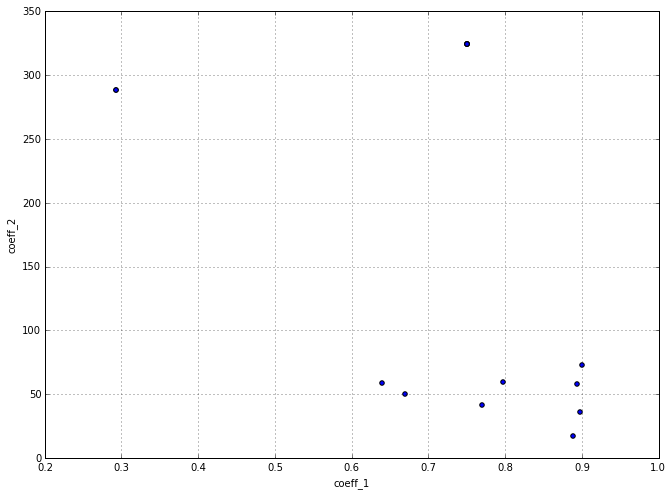

In [106]:
t = '20140402 19'
muv[t1].plot('coeff_1', 'coeff_2', kind='scatter')

In [87]:
muv = df[df.filename.str.contains('-muv_')]
fuv = df[df.filename.str.contains('-fuv_')]

In [93]:
rcParams['figure.figsize'] = (11,8)

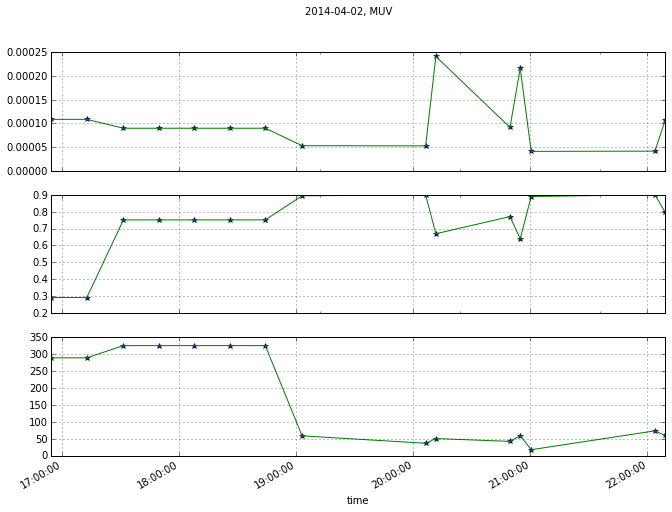

In [104]:
t1 = '20140402'
fig, axes = subplots(nrows=3)
fig.suptitle('2014-04-02, MUV')
for ax,i in zip(axes, range(3)):
    muv[t1]['coeff_'+str(i)].plot(ax=ax,style='*')
    muv[t1]['coeff_'+str(i)].plot(ax=ax)
savefig('t1_muv.png', dpi=150)

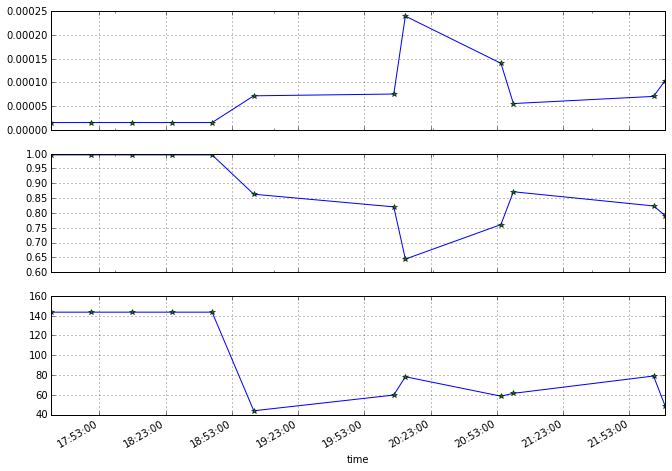

In [101]:
t1 = '20140402'
fig, axes = subplots(nrows=3)
for ax,i in zip(axes, range(3)):
    fuv[t1]['coeff_'+str(i)].plot(ax=ax)
    fuv[t1]['coeff_'+str(i)].plot(ax=ax,style='*')

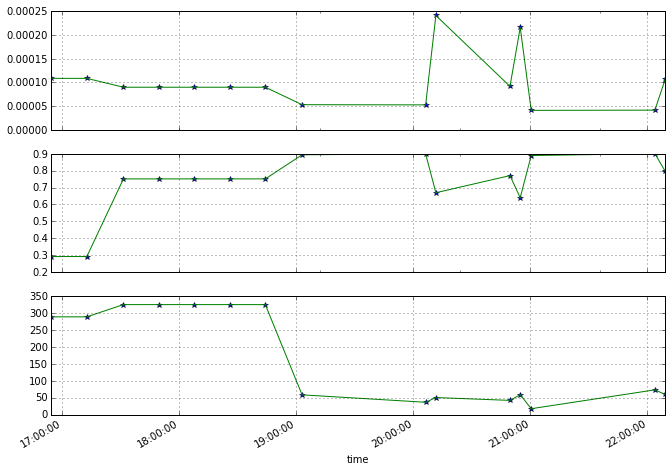

In [102]:
t2 = '20140521'
fig, axes = subplots(nrows=3)
fig
for ax,i in zip(axes, range(3)):
    muv[t1]['coeff_'+str(i)].plot(ax=ax, style='*')
    muv[t1]['coeff_'+str(i)].plot(ax=ax,)

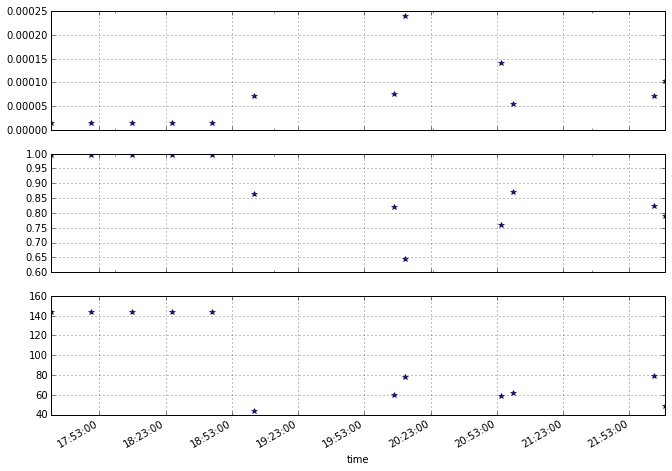

In [97]:
t2 = '20140521'
fig, axes = subplots(nrows=3)
for ax,i in zip(axes, range(3)):
    fuv[t1]['coeff_'+str(i)].plot(ax=ax, style='*')